In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [2]:
import av
import torch
from torch import nn
from fastai.vision.all import *
import timm
from sklearn.metrics import roc_curve, auc

In [3]:
dataroot_path = Path('../temset')

In [4]:
dataroot_path.ls()

(#7) [Path('../temset/cutouts'),Path('../temset/labels.csv'),Path('../temset/cutout-frames'),Path('../temset/.~lock.labels.csv#'),Path('../temset/frames'),Path('../temset/.ipynb_checkpoints'),Path('../temset/videos')]

In [5]:
df = pd.read_csv(dataroot_path / 'labels.csv', dtype={'filename': str, 'timeline_label': str,'timeline_label2': str, 'overlap': bool, 'timeline_phase_label': str, 'timeline_task_label': str, 'timeline_action_label': str, 'valid': bool})

In [6]:
df.head()

,filename,timeline_label,overlap,timeline_label2,timeline_phase_label,timeline_task_label,timeline_action_label,valid
0,surg-001_2023-08-01_145401_VID001_0.000000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False
1,surg-001_2023-08-01_145401_VID001_0.224000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False
2,surg-001_2023-08-01_145401_VID001_0.440000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False
3,surg-001_2023-08-01_145401_VID001_0.664000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False
4,surg-001_2023-08-01_145401_VID001_0.880000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False


In [7]:
cutouts_path = dataroot_path/'cutout-frames'

In [8]:
cutouts = cutouts_path.ls()

In [9]:
@patch
def ls_sorted(self: Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs):
        n = len(self)
        img0, img1, img2 = self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1, t2 = tensor(img0), tensor(img1), tensor(img2)
            t0, t1, t2 = t0.permute(2, 0, 1), t1.permute(2, 0, 1), t2.permute(2, 0, 1)
        else:
            t0, t1, t2 = img0, img1, img2
        return show_image(torch.cat([t0, t1, t2], dim=2), ctx=ctx, **kwargs)

In [10]:
frames = [i for i in cutouts[0].ls()][0:10]
frames

[Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/11.jpg'),
 Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/27.jpg'),
 Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/13.jpg'),
 Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/17.jpg'),
 Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/1.jpg'),
 Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/2.jpg'),
 Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/9.jpg'),
 Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/12.jpg'),
 Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/15.jpg'),
 Path('../temset/cutout-frames/surg-001_2023-08-01_152123_VID008_480.832000/5.jpg')]

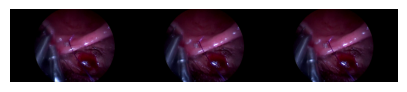

In [11]:
ImageTuple(PILImage.create(fn) for fn in frames).show();

In [12]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=15):
        store_attr()

    def encodes(self, r):
        "Get a list of images files for folder path"
        frames = (cutouts_path/r['filename']).ls_sorted()
        
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [13]:
tfm = ImageTupleTfm(seq_len=15)
# tfm (cutouts[0]).show();

In [14]:
df.head()

,filename,timeline_label,overlap,timeline_label2,timeline_phase_label,timeline_task_label,timeline_action_label,valid
0,surg-001_2023-08-01_145401_VID001_0.000000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False
1,surg-001_2023-08-01_145401_VID001_0.224000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False
2,surg-001_2023-08-01_145401_VID001_0.440000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False
3,surg-001_2023-08-01_145401_VID001_0.664000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False
4,surg-001_2023-08-01_145401_VID001_0.880000,Setup.Scope.No Action,False,Setup.Scope.No Action,Setup,Scope,No Action,False


In [15]:
def splitter(df):
    train = df.index[~df['valid']].tolist()
    valid = df.index[df['valid']].tolist()
    return train, valid

def get_phase_label(r):
    return r['timeline_phase_label']

def get_task_label(r):
    return r['timeline_task_label']

def get_action_label(r):
    return r['timeline_action_label']

# Create custom data loader function
def get_tls_dataloaders(df, bs=8, image_size=(90, 160), seq_len=30, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = splitter(df)
    itfm = ImageTupleTfm(seq_len=seq_len)
    phases = list(np.unique(df.timeline_phase_label.values))
    tasks = list(np.unique(df.timeline_task_label.values))
    actions = list(np.unique(df.timeline_action_label.values))
    len(phases)

    ds = Datasets(df, 
                  tfms=[[itfm], 
                        [get_phase_label, Categorize(vocab=phases)], 
                        [get_task_label, Categorize(vocab=tasks)], 
                        [get_action_label, Categorize(vocab=actions)]], 
                  splits=splits,
                  n_inp=1)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size, method=ResizeMethod.Squish), ToTensor],
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

dls = get_tls_dataloaders(df, bs=4, image_size=(192, 192), seq_len=30)

In [16]:
dls.c

(#3) [5,12,22]

In [17]:
x, y_phases, y_tasks, y_actions = dls.one_batch()
torch.stack(x,dim=1).shape, y_phases.shape, y_tasks.shape, y_actions.shape

(torch.Size([4, 30, 3, 192, 192]),
 torch.Size([4]),
 torch.Size([4]),
 torch.Size([4]))

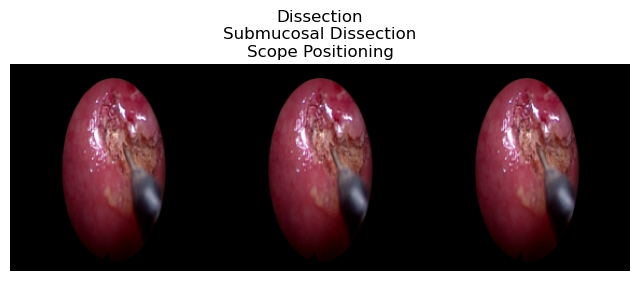

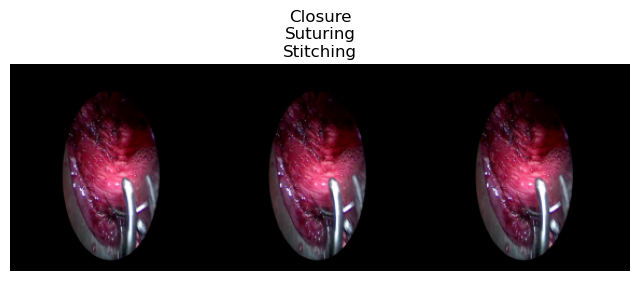

In [18]:
dls.show_batch(max_n=2,figsize=(8,4))

In [19]:
# defining loss for each componet in the triplet taxonomy
def phase_loss(preds, phase_targs, task_targs, action_targs, **kwargs): 
    return CrossEntropyLossFlat(reduction='mean')(preds[:, :dls.c[0]], phase_targs, **kwargs)

def task_loss(preds, phase_targs, task_targs, action_targs, **kwargs):
    s, e = dls.c[0], dls.c[0] + dls.c[1]
    return CrossEntropyLossFlat(reduction='mean')(preds[:, s:e], task_targs, **kwargs)

def action_loss(preds, phase_targs, task_targs, action_targs, **kwargs): 
    s, e = dls.c[0] + dls.c[1], dls.c[0] + dls.c[1] + dls.c[2]
    return CrossEntropyLossFlat(reduction='mean')(preds[:, s:e], action_targs, **kwargs)

def custom_loss(preds, phase_targs, task_targs, action_targs, **kwargs): 
    alpha = 0.33
    return (alpha * phase_loss(preds, phase_targs, task_targs, action_targs, **kwargs) + 
            (alpha * task_loss(preds, phase_targs, task_targs, action_targs, **kwargs)) + 
            (alpha * action_loss(preds, phase_targs, task_targs, action_targs, **kwargs)))

# defining error rate for each robotic hand tools
def phase_err(preds, phase_targs, task_targs, action_targs, **kwargs): 
    return error_rate(preds[:, :dls.c[0]], phase_targs, **kwargs)

def task_err(preds, phase_targs, task_targs, action_targs, **kwargs): 
    s, e = dls.c[0], dls.c[0] + dls.c[1]
    return error_rate(preds[:, s:e], task_targs, **kwargs)

def action_err(preds, phase_targs, task_targs, action_targs, **kwargs): 
    s, e = dls.c[0] + dls.c[1], dls.c[0] + dls.c[1] + dls.c[2]
    return error_rate(preds[:, s:e], action_targs)

# defining combined error rate 
def total_err(preds, phase_targs, task_targs, action_targs, **kwargs): 
    alpha = 0.33
    return ((alpha*phase_err(preds, phase_targs, task_targs, action_targs, **kwargs)) + 
            (alpha*task_err(preds, phase_targs, task_targs, action_targs, **kwargs)) + 
            (alpha*action_err(preds, phase_targs, task_targs, action_targs, **kwargs)))

# Define custom F1 score functions
def phase_f1(preds, phase_targs, task_targs, action_targs, **kwargs):
    preds_phase = preds[:, :dls.c[0]].argmax(dim=1)
    return F1Score(average='macro')(preds_phase, phase_targs, **kwargs)

def task_f1(preds, phase_targs, task_targs, action_targs, **kwargs):
    s, e = dls.c[0], dls.c[0] + dls.c[1]
    preds_task = preds[:, s:e].argmax(dim=1)
    return F1Score(average='macro')(preds_task, task_targs, **kwargs)

def action_f1(preds, phase_targs, task_targs, action_targs, **kwargs):
    s, e = dls.c[0] + dls.c[1], dls.c[0] + dls.c[1] + dls.c[2]
    preds_action = preds[:, s:e].argmax(dim=1)
    return F1Score(average='macro')(preds_action, action_targs, **kwargs)

def total_f1(preds, phase_targs, task_targs, action_targs, **kwargs):
    alpha = 0.33
    phase_f1_score = phase_f1(preds, phase_targs, task_targs, action_targs, **kwargs)
    task_f1_score = task_f1(preds, phase_targs, task_targs, action_targs, **kwargs)
    action_f1_score = action_f1(preds, phase_targs, task_targs, action_targs, **kwargs)
    return alpha * phase_f1_score + alpha * task_f1_score + alpha * action_f1_score

# Define metrics list
metrics = [phase_err, task_err, action_err, total_err, phase_f1, task_f1, action_f1, total_f1]

In [20]:
cbs = [GradientAccumulation(n_acc=8)]

In [21]:
n_out = dls.c.sum()  # Example output dimension, set this to len(dls.vocab) if available

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, lstm_outputs):
        # lstm_outputs: [seq_len, batch_size, hidden_size]
        attn_weights = F.softmax(self.attention(lstm_outputs), dim=0)
        # attn_weights: [seq_len, batch_size, 1]
        weighted_output = torch.sum(attn_weights * lstm_outputs, dim=0)
        # weighted_output: [batch_size, hidden_size]
        return weighted_output

In [22]:
class STALNet(Module):
    def __init__(self, arch='swinv2_base_window12_192_22k', n_out=n_out, pretrained=True, num_rnn_layers=2, seq_len=30):
        super().__init__()
        body, _ = create_timm_model(arch, pretrained=pretrained, n_out=0)
        self.encoder = TimeDistributed(nn.Sequential(body[:-1], nn.Flatten()))  # Using the encoder part, excluding the final layer
        self.lstm_layers = nn.ModuleList([nn.LSTM(1024, 1024, num_layers=num_rnn_layers, batch_first=True) for _ in range(seq_len)])
        self.attention = Attention(1024)
        self.head = LinBnDrop(1024, n_out)
        
    def forward(self, x):
        x = torch.stack(x, dim=1)
        # print(f"Input shape to encoder: {x.shape}")  # Debug: Input shape to encoder
        x = self.encoder(x)
        # print(f"Output shape from encoder: {x.shape}")  # Debug: Output shape from encoder
        
        x = x.view(x.size(0), -1, 1024)  # Ensure the correct shape for LSTM
        # print(f"Reshaped output for LSTM: {x.shape}")  # Debug: Reshaped output for LSTM

        lstm_outputs = []
        for i, lstm in enumerate(self.lstm_layers):
            out, _ = lstm(x)
            lstm_outputs.append(out[:, -1])
        
        lstm_outputs = torch.stack(lstm_outputs)
        # print(f"LSTM outputs shape: {lstm_outputs.shape}")  # Debug: LSTM outputs shape
        
        # Apply attention mechanism
        out = self.attention(lstm_outputs)
        # print(f"Attention weighted output shape: {out.shape}")  # Debug: Attention weighted output shape
        
        out = self.head(out)
        # print(f"Output shape from head: {out.shape}")  # Debug: Output shape from head
        return out

def stalnet_splitter(model):
    return [params(model.encoder), params(model.lstm_layers) + params(model.head)]

model = STALNet(seq_len=30).cuda()  # Adjust the seq_len parameter as needed

learn = Learner(dls, model,
                loss_func=custom_loss,
                metrics=metrics,
                cbs=cbs,
                splitter=stalnet_splitter).to_fp16()

/home/bcu/miniconda3/lib/python3.12/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name swinv2_base_window12_192_22k to current swinv2_base_window12_192.ms_in22k.
  model = create_fn(
/home/bcu/miniconda3/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/bcu/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/bcu/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:498: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


SuggestedLRs(valley=3.0199516913853586e-05, slide=0.009120108559727669)

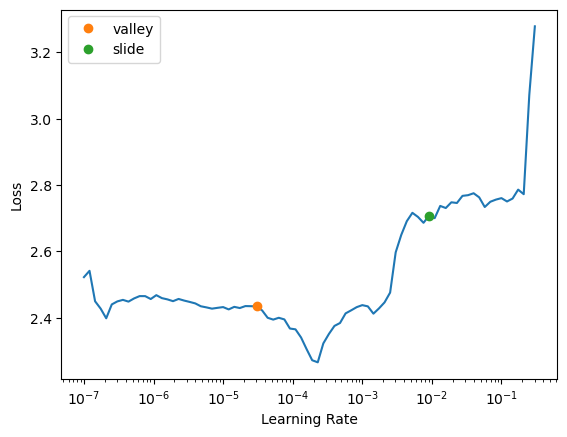

In [23]:
# Find learning rate
learn.lr_find(suggest_funcs=(valley, slide))

In [24]:
learn.fit_one_cycle(12, 1e-4)

epoch,train_loss,valid_loss,phase_err,task_err,action_err,total_err,phase_f1,task_f1,action_f1,total_f1,time
0,1.004759,0.755093,0.045094,0.157732,0.468163,0.221426,0.932768,0.793523,0.447214,0.717257,2:33:50
1,0.966804,0.777420,0.051868,0.175731,0.512290,0.244162,0.922670,0.770247,0.401160,0.691046,2:33:41
2,0.882107,0.715777,0.057480,0.163344,0.468357,0.227429,0.916296,0.781598,0.437122,0.704555,2:35:21
3,0.644826,0.596096,0.038127,0.129863,0.423263,0.195113,0.937242,0.817617,0.473784,0.735452,2:34:26
4,0.540190,0.570017,0.032127,0.111090,0.403522,0.180424,0.951134,0.841139,0.493556,0.754324,2:27:58
5,0.478061,0.478929,0.021676,0.087865,0.361138,0.155324,0.964895,0.871191,0.536661,0.783006,2:25:40
6,0.384343,0.448881,0.021289,0.074705,0.304819,0.132268,0.963254,0.886146,0.595199,0.806718,2:25:43
7,0.288062,0.454577,0.017225,0.064060,0.286627,0.121411,0.970277,0.901826,0.611422,0.819563,2:25:12
8,0.176152,0.420805,0.017805,0.061931,0.260112,0.112150,0.970330,0.904750,0.647978,0.832609,2:24:25
9,0.083916,0.453780,0.015870,0.058254,0.243081,0.104678,0.972786,0.909980,0.664324,0.840540,2:25:37


In [25]:
learn.path=Path('./models')
learn.export('lstm-swin-stg1-v01.pkl')

In [26]:
learn.lr_find(suggest_funcs=(valley,slide))

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(24, slice(1e-4/400, 1e-4/4))

In [ ]:
# learn=load_learner('./models/lstm-swin-v01.pkl',cpu=False)
# learn.dls=dls

In [ ]:
learn.path=Path('./models')
learn.export('lstm-swin-stg2-v01.pkl')

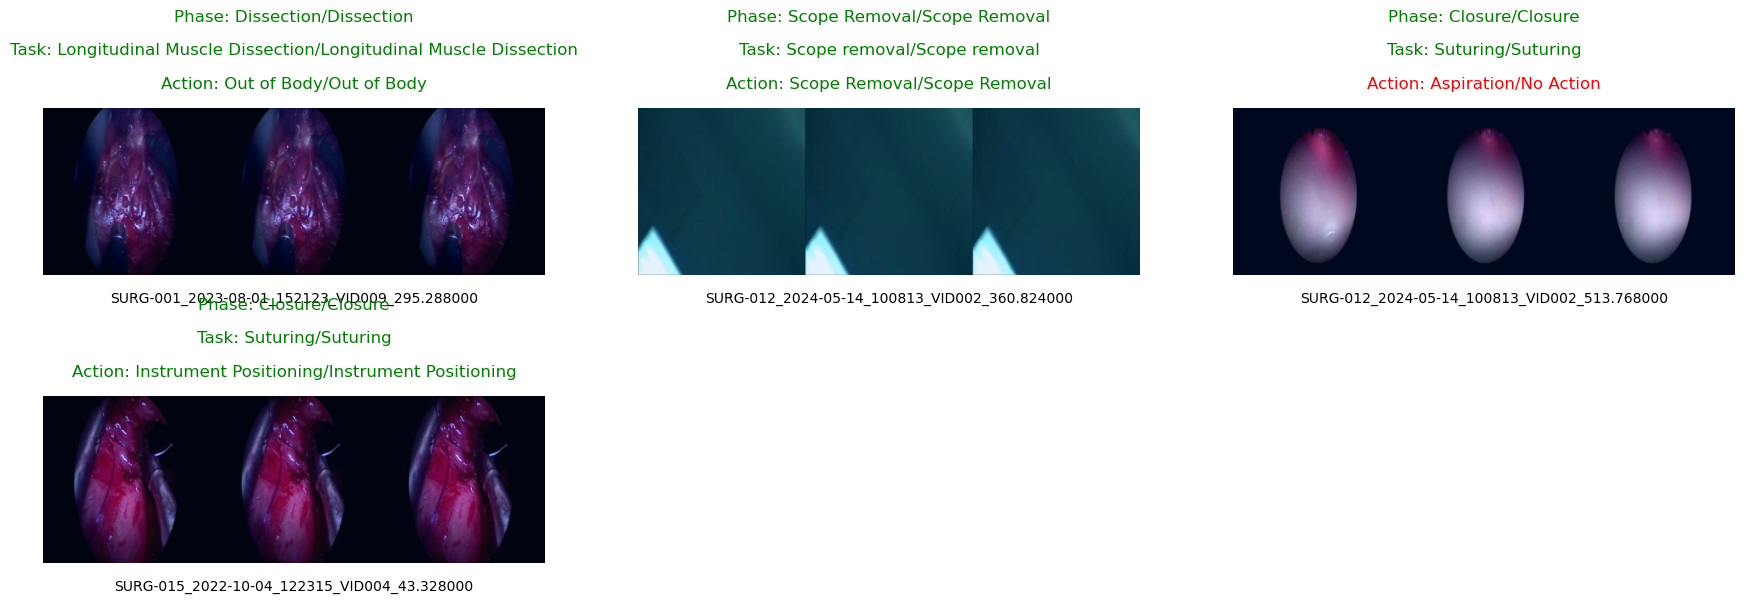

In [30]:
from PIL import Image, ImageOps

# Custom show_results function using @typedispatch
@typedispatch
def custom_show_results(x: ImageTuple, y: tuple, samples, outs, filenames, ctxs=None, max_n=9, nrows=None, ncols=3, figsize=None, encoder_name='convnext', **kwargs):
    if figsize is None: 
        figsize = (ncols*6, max_n//ncols * 2)
    if ctxs is None: 
        ctxs = get_grid(min(torch.stack(samples[0],dim=1).shape[0], max_n), nrows=nrows, ncols=ncols, figsize=figsize)

    phase_classes = dls.c[0]
    task_classes = dls.c[1]
    action_classes = dls.c[2]

    x = torch.stack(x,dim=1)

    for i, ctx in enumerate(ctxs):
        video_clip = x[i]
        filename = filenames[i].upper()  # Convert filename to uppercase
        true_phase, true_task, true_action = y[0][i], y[1][i], y[2][i]

        pred_phase = outs[i][:phase_classes].argmax().item()
        pred_task = outs[i][phase_classes:phase_classes + task_classes].argmax().item()
        pred_action = outs[i][phase_classes + task_classes:phase_classes + task_classes + action_classes].argmax().item()

        phase_color = 'green' if pred_phase == true_phase else 'red'
        task_color = 'green' if pred_task == true_task else 'red'
        action_color = 'green' if pred_action == true_action else 'red'

        phase_text = f"Phase: {dls.vocab[0][pred_phase]}/{dls.vocab[0][true_phase]}"
        task_text = f"Task: {dls.vocab[1][pred_task]}/{dls.vocab[1][true_task]}"
        action_text = f"Action: {dls.vocab[2][pred_action]}/{dls.vocab[2][true_action]}"

        # Ensure video_clip is an ImageTuple and call show method
        if isinstance(video_clip, ImageTuple):
            video_clip.show(ctx=ctx)
        else:
            # Fallback to showing concatenated frames if not an ImageTuple
            seq_len = video_clip.shape[0]
            first_frame = video_clip[0]
            middle_frame = video_clip[seq_len // 2]
            last_frame = video_clip[-1]
            concatenated = torch.cat([first_frame, middle_frame, last_frame], dim=2)
            concatenated = (concatenated - concatenated.min()) / (concatenated.max() - concatenated.min())  # Normalize to [0, 1]
            concatenated = concatenated.permute(1, 2, 0).cpu().numpy()  # Convert to HWC and move to CPU
            ctx.imshow(concatenated)
            ctx.axis('off')

        # Print titles above the image with increased spacing
        ctx.text(0.5, 1.5, phase_text, color=phase_color, fontsize=12, ha='center', va='bottom', transform=ctx.transAxes)
        ctx.text(0.5, 1.3, task_text, color=task_color, fontsize=12, ha='center', va='bottom', transform=ctx.transAxes)
        ctx.text(0.5, 1.1, action_text, color=action_color, fontsize=12, ha='center', va='bottom', transform=ctx.transAxes)

        # Print filename at the bottom in uppercase
        ctx.text(0.5, -0.10, filename, color='black', fontsize=10, ha='center', va='top', transform=ctx.transAxes)

    plt.tight_layout()
    # plt.subplots_adjust(hspace=0.8)
    
    # Save the figure with high resolution and add transparent border
    plt.savefig(f'show_results_tmp_{encoder_name}.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
    # Add transparent border to the saved image
    img = Image.open(f'show_results_tmp_{encoder_name}.png')
    border_size = 20  # Adjust the border size as needed
    img_with_border = ImageOps.expand(img, border=(border_size, border_size, border_size, border_size), fill=(255, 255, 255, 0))
    img_with_border.save(f'show_results_{encoder_name}.png')

# Custom Learner show_results method using @patch
@patch
def show_results(self: Learner, b=None, max_n=9, nrows=None, ncols=3, figsize=None, shuffle=True, **kwargs):
    if b is None: 
        dl = self.dls.valid.new(shuffle=shuffle)  # Shuffle the dataloader to get diverse samples
        b = dl.one_batch()
    indices = dl.get_idxs()[:len(b[0])]  # Get indices of the batch
    filenames = [self.dls.valid_ds.items.iloc[i]['filename'] for i in indices]  # Extract filenames using indices
    _, _, preds = self.get_preds(dl=[b], with_decoded=True)
    custom_show_results(b[0], b[1:], (b[0], b[1:]), preds, filenames, max_n=max_n, nrows=nrows, ncols=ncols, figsize=figsize, encoder_name='swinv2', **kwargs)

# Now you can use the custom show_results function with your Learner
learn.show_results()


In [31]:
import torch

def plot_roc_curve(ax, target_name, preds, targs, class_names, colors):
    sorted_indices = sorted(range(len(class_names)), key=lambda k: class_names[k])
    for i in sorted_indices:
        class_name = class_names[i]
        fpr, tpr, _ = roc_curve((targs == i).cpu().numpy(), preds[:, i].cpu().numpy())
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{class_name} (area = {roc_auc:.2f})', color=colors[i % len(colors)])
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {target_name}')
    ax.legend(loc="lower right", fontsize='small', ncol=1)

def plot_roc_curves(learn, encoder_name, save_separate=False):
    """
    Plots the ROC curves for phase, task, or action targets.
    
    Parameters:
    learn: Learner object
    encoder_name: str, name of the encoder to make the filenames unique
    save_separate: bool, if True saves each ROC curve in separate files, otherwise saves in a single file.
    """
    # Get predictions and true labels from the validation set
    preds, targs = learn.get_preds(ds_idx=1)  # 1 indicates the validation set
    
    # Get class counts and class names
    phase_classes = learn.dls.c[0]
    task_classes = learn.dls.c[1]
    action_classes = learn.dls.c[2]
    phase_names = learn.dls.vocab[0]
    task_names = learn.dls.vocab[1]
    action_names = learn.dls.vocab[2]
    
    # Define color shades
    colors = plt.cm.tab20.colors  # Use tab20 colormap for colors

    if save_separate:
        # Plot and save each ROC curve separately
        fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
        triplet_preds = preds[:, :phase_classes]
        triplet_targs = targs[0]
        plot_roc_curve(ax, 'Phase', triplet_preds, triplet_targs, phase_names, colors)
        plt.tight_layout()
        plt.savefig(f"roc_phase_{encoder_name}.png", dpi=600)
        plt.close(fig)

        fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
        triplet_preds = preds[:, phase_classes:phase_classes + task_classes]
        triplet_targs = targs[1]
        plot_roc_curve(ax, 'Task', triplet_preds, triplet_targs, task_names, colors)
        plt.tight_layout()
        plt.savefig(f"roc_task_{encoder_name}.png", dpi=600)
        plt.close(fig)

        fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
        triplet_preds = preds[:, phase_classes + task_classes:phase_classes + task_classes + action_classes]
        triplet_targs = targs[2]
        plot_roc_curve(ax, 'Action', triplet_preds, triplet_targs, action_names, colors)
        plt.tight_layout()
        plt.savefig(f"roc_action_{encoder_name}.png", dpi=600)
        plt.close(fig)
    else:
        # Plot ROC curves in a single image
        fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=600)

        triplet_preds = preds[:, :phase_classes]
        triplet_targs = targs[0]
        plot_roc_curve(axs[0], 'Phase', triplet_preds, triplet_targs, phase_names, colors)

        triplet_preds = preds[:, phase_classes:phase_classes + task_classes]
        triplet_targs = targs[1]
        plot_roc_curve(axs[1], 'Task', triplet_preds, triplet_targs, task_names, colors)

        triplet_preds = preds[:, phase_classes + task_classes:phase_classes + task_classes + action_classes]
        triplet_targs = targs[2]
        plot_roc_curve(axs[2], 'Action', triplet_preds, triplet_targs, action_names, colors)

        plt.tight_layout()
        plt.savefig(f"roc_taxonomy_{encoder_name}.png", dpi=600)
        plt.show()

# Example usage
plot_roc_curves(learn, encoder_name='swinv2', save_separate=True)


In [32]:
def show_triplet_metrics(learn, encoder_name, triplet_name):
    # Getting predictions and targets from the validation set
    preds, targs = learn.get_preds(ds_idx=1)
    
    phase_classes = learn.dls.c[0]
    task_classes = learn.dls.c[1]
    action_classes = learn.dls.c[2]

    if triplet_name == 'phase':
        preds = preds[:, :phase_classes]
        targs = targs[0]
        class_names = learn.dls.vocab[0]
    elif triplet_name == 'task':
        preds = preds[:, phase_classes:phase_classes + task_classes]
        targs = targs[1]
        class_names = learn.dls.vocab[1]
    elif triplet_name == 'action':
        preds = preds[:, phase_classes + task_classes:]
        targs = targs[2]
        class_names = learn.dls.vocab[2]
    else:
        raise ValueError("Invalid triplet name. Choose from 'phase', 'task', or 'action'.")

    # Initialize lists to store metrics
    names = []
    accuracies = []
    f1_scores = []
    accuracy_stds = []
    f1_stds = []

    # Calculate metrics for each class
    for i, class_name in enumerate(class_names):
        class_preds = (preds.argmax(dim=1) == i).float()
        class_targs = (targs == i).float()

        acc = (class_preds == class_targs).float().mean().item()
        f1 = F1Score(average='macro')(class_preds, class_targs).item()
        
        # Compute standard deviation
        acc_std = np.std((class_preds.cpu().numpy() == class_targs.cpu().numpy()).astype(float))
        f1_score = F1Score(average=None)(class_preds, class_targs)
        f1_scores_np = f1_score.detach().cpu().numpy() if isinstance(f1_score, torch.Tensor) else np.array(f1_score)
        f1_std = np.std(f1_scores_np) if len(f1_scores_np) > 1 else 0  # Handling single class case
        
        names.append(class_name)
        accuracies.append(acc)
        f1_scores.append(f1)
        accuracy_stds.append(acc_std)
        f1_stds.append(f1_std)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Name': names,
        'Accuracy': [f"{acc:.2f} ± {acc_std:.2f}" for acc, acc_std in zip(accuracies, accuracy_stds)],
        'F1 Score': [f"{f1:.2f} ± {f1_std:.2f}" for f1, f1_std in zip(f1_scores, f1_stds)]
    })
    
    # Save DataFrame to CSV
    df.to_csv(f"metrics_std_{triplet_name}_{encoder_name}.csv", index=False)
    
    # Display DataFrame
    display(df)
    
    return df


In [33]:
# Example usage
df = show_triplet_metrics(learn, 'swinv2', 'phase')

,Name,Accuracy,F1 Score
0,Closure,0.99 ± 0.08,0.99 ± 0.00
1,Dissection,0.99 ± 0.11,0.99 ± 0.00
2,Scope Removal,1.00 ± 0.03,1.00 ± 0.00
3,Setup,0.99 ± 0.10,0.97 ± 0.03
4,Specimen Removal,1.00 ± 0.02,0.99 ± 0.01


In [34]:
df = show_triplet_metrics(learn, 'swinv2', 'task')

,Name,Accuracy,F1 Score
0,Circular Muscle Dissection,0.98 ± 0.12,0.95 ± 0.04
1,Instrument,1.00 ± 0.02,0.92 ± 0.08
2,Landmarking,0.99 ± 0.09,0.97 ± 0.03
3,Longitudinal Muscle Dissection,0.99 ± 0.11,0.97 ± 0.02
4,Mucosal Dissection,0.98 ± 0.15,0.95 ± 0.04
5,Pressure,0.99 ± 0.08,0.93 ± 0.07
6,Scope,0.99 ± 0.09,0.96 ± 0.04
7,Scope removal,1.00 ± 0.03,1.00 ± 0.00
8,Site,1.00 ± 0.07,0.82 ± 0.18
9,Specimen Removal,1.00 ± 0.02,0.99 ± 0.01


In [35]:
df = show_triplet_metrics(learn, 'swinv2', 'action')

,Name,Accuracy,F1 Score
0,Aspiration,0.97 ± 0.18,0.85 ± 0.13
1,Bleeding,0.99 ± 0.08,0.80 ± 0.19
2,Clipping Suture,1.00 ± 0.06,0.91 ± 0.09
3,Debris Wash,1.00 ± 0.01,0.50 ± 0.50
4,Deflate Rectum,0.99 ± 0.08,0.89 ± 0.11
5,Dissection,0.93 ± 0.26,0.86 ± 0.10
6,Fluid Wash,1.00 ± 0.06,0.73 ± 0.27
7,Haemostasis,1.00 ± 0.07,0.77 ± 0.23
8,Haemostatis,1.00 ± 0.03,0.85 ± 0.15
9,Inflate Rectum,1.00 ± 0.06,0.87 ± 0.13
